In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as c
import yssbtmpy as tm
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from matplotlib.patches import Circle, FancyArrowPatch, Arc
from matplotlib.ticker import LogLocator

from multiprocessing import Pool


from accutil import (
    wrap_000360_to_180180, wrap_180180_to_000360, 
    set_perpmodel, set_phaethon, set_model_aspect,
    set_particle, linticker, set_spl, 
    logxticker, logyticker, logticker, calc_traj, CHEMDICT,
    QprbarSpline, QprbarSunSpline, QPRDIR)

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

In [4]:
RADII = np.concatenate([np.arange(0.5, 1, 0.1),
                       np.arange(1, 16.1, 0.5),
                       np.arange(20, 41, 5)])
FIGDIR = Path("./figs")
DATADIR = Path("./data")
PH_0_CALC = np.arange(0., 360., 1.)
TH_0_CALC = np.arange(10, 171, 10)

ASPANGS = np.array([90, 45])*u.deg
RHELS = np.arange(0.1, 1, 0.1) * u.au
DIAMS = np.arange(0.5, 30, 0.5) * u.km 
PROTS = np.array([3, 6]) * u.h
TRUE_ANOMS = np.arange(0, 360, 15)

TPM_BASE = dict(a_bond=0.1, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

chemkeys = list(CHEMDICT.keys())
n_chem = len(chemkeys)
n_radii = len(RADII)

##### For xarray setup #####
'''
* asp = aspect angle
* r_h = heliocentric distance
* chem = chemical composition 
* D = effective diameter in km
* P = rotational period in h
* r = particle radius in um
* ph = initial longitudinal position (0 ~ 360 deg)
'''
N_ASP = ASPANGS.shape[0]
N_RH = RHELS.shape[0]
N_D = DIAMS.shape[0]
N_P = PROTS.shape[0]
N_R = RADII.shape[0]
N_PH = PH_0_CALC.shape[0]
N_TH = TH_0_CALC.shape[0]
N_F = TRUE_ANOMS.shape[0]

XRDIMS1 = ('asp', 'r_h', 'chem', 'D', 'P', 'r', 'ph')
XRCOOR1 = dict(
    asp=ASPANGS.value,
    r_h=RHELS.value,
    chem=chemkeys,
    D=DIAMS.value,
    P=PROTS.value,
    r=RADII,
    ph=PH_0_CALC
)
XRUNIT1 = dict(asp=u.deg, r_h=u.au, chem='', D=u.km, P=u.h, r=u.um, ph=u.deg)

XRDIMS2 = ('chem', 'f', 'r', 'th', 'ph')
XRCOOR2 = dict(
    chem=chemkeys,
    f=TRUE_ANOMS,
    r=RADII,
    th=TH_0_CALC,
    ph=PH_0_CALC
)
XRUNIT2 = dict(chem='', f=u.deg, r=u.um, th=u.deg, ph=u.deg)
####################################

## One-Time Calcuation
Calculate the accelerations depending on the parameters (diameter, rotational period, true anomaly, particle radius, longitude, and latitude):

In [5]:
######### multi thread case ########

a_fict_path = DATADIR/f"acc_fictmodels.nc"
npool_optimal = 7

if not a_fict_path.exists():
    m_ficts = {}
    for asp in ASPANGS:
        for rh in RHELS:
            for d in DIAMS:
                for p in PROTS:
                    params = dict()
                    m_fict = set_model_aspect(r_hel=rh, aspect_deg=asp, 
                                              diam_eff=d, rot_period=p, 
                                              **TPM_BASE)
                    m_fict.calc_temp(full=False)
                    m_ficts[asp, rh, d, p] = m_fict

    a_ficts = np.zeros((N_ASP, N_RH, 2, N_D, N_P, N_R, N_PH))
    for i_c, chem in enumerate(chemkeys):
        # Splining Qprbar is the most time-consuming part (~ 20ms)
        # compared to all others (< 1ms), so better to give a priori if possible.
        kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                    Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
        print(chem, end=' ')
        for i_asp, asp in enumerate(ASPANGS):
            print(asp)
            for i_rh, rh in enumerate(RHELS):    
                print(f"{rh:.2f}", end=' ')
                for i_d, d in enumerate(DIAMS):
                    print('.', end='')
                    for i_p, p in enumerate(PROTS):
                        sb_fict = m_ficts[asp, rh, d, p]

                        def _acc_multi(radius):  # d, p, sb, Qpr are already defined outside.
                            acc_fict = []
                            for ph in PH_0_CALC:
                                kw_p = dict(radius_um=radius, chem=chem, 
                                            init_th=90, init_ph=ph, **kw_Q)
                                p = set_particle(sb_fict, **kw_p)
                                acc_fict.append(np.sum(p.trace_a_all_xyz[-1]
                                                       * p.trace_rvec[-1]))
                            return radius, np.array(acc_fict)

                        pool = Pool(npool_optimal)
                        args = [RADII]
                        results = np.array(pool.starmap(_acc_multi, np.array(args).T))
                        pool.close()
                        for i_r, res in enumerate(results):
                            a_ficts[i_asp, i_rh, i_c, i_d, i_p, i_r] = res[1]
                print('')
    a_fict = xr.Dataset(
        {'fict': (XRDIMS1, a_ficts)},
        coords=XRCOOR1)

    for k, v in XRUNIT1.items():
        a_fict['fict'][k].attrs['units'] = str(v)

    a_fict.to_netcdf(a_fict_path)

a_fict = xr.open_dataset(a_fict_path)
# a_perps = np.load(a_perps_path, allow_pickle=True)[()]
# a_th45s = np.load(a_th45s_path, allow_pickle=True)[()]


a_phaes_path = DATADIR/"acc_phae.nc"
    
if not a_phaes_path.exists():
    m_phaes = {}
    for f in TRUE_ANOMS:
        m_phae = set_phaethon(true_anom=f)
        m_phae.calc_temp(full=False)
        m_phaes[f] = m_phae

    a_phaes = np.zeros((2, N_F, N_R, N_TH, N_PH))
    for i_c, chem in enumerate(chemkeys):
        # Splining Qprbar is the most time-consuming part (~ 20ms)
        # compared to all others (< 1ms), so better to give a priori if possible.
        kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                    Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
        print(chem, end=' ')
        for i_f, f in enumerate(TRUE_ANOMS):
            print(f, end=' ')
            sb_phae = m_phaes[f]

            def _acc_multi(radius):  # f, sb, Qpr are already defined outside.
                acc_phae = np.zeros((N_TH, N_PH))
                for i_th, th in enumerate(TH_0_CALC):
                    for i_ph, ph in enumerate(PH_0_CALC):
                        kw_p = dict(radius_um=radius, chem=chem, 
                                    init_th=th, init_ph=ph, **kw_Q)
                        p_phae = set_particle(sb_phae, **kw_p)
                        acc_phae[i_th, i_ph] = (np.sum(p_phae.trace_a_all_xyz[-1]
                                                * p_phae.trace_rvec[-1]))
                return radius, acc_phae

            pool = Pool(npool_optimal)
            args = [RADII]
            results = np.array(pool.starmap(_acc_multi, np.array(args).T))
            pool.close()

            for i_r, res in enumerate(results):
                a_phaes[i_c, i_f, i_r] = res[1]
    a_phae = xr.Dataset(
        {'h18': (XRDIMS2, a_phaes)},
        coords=XRCOOR2)

    for mod_id in ['h18']:
        for k, v in XRUNIT2.items():
            a_phae[mod_id][k].attrs['units'] = str(v)

    a_phae.to_netcdf(a_phaes_path)

a_phae = xr.open_dataset(a_phaes_path)

# Change true anomaly to -180 ~ +180
a_phae = a_phae.assign_coords(f=wrap_000360_to_180180(a_phae.f))
a_phae = a_phae.sortby('f')

print("Loading and Setting Finished.")

Loading and Setting Finished.


The reason I used ``npool_optimal = 7`` is because using 7 thread seemed the fastest for my laptop (see **Timing Benchmark** section below).

<details><summary><b>single thread case</b> (click)</summary>
<p>

```python
######### single thread case ########
a_perps = {}
a_th45s = {}
a_phaes = {}

for chem in chemkeys:
    # Splining Qprbar is the most time-consuming part (~ 20ms)
    # compared to all others (< 1ms), so better to give a priori if possible.
    kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
    for d in DIAMS:
        for p in PROTS:
            sb_perp = m_perps[d, p]
            sb_th45 = m_th45s[d, p]
            for r in RADII:
                print(f"{r:.1f}", end=' ')
                acc_perp = []
                acc_th45 = []
                for ph in PH_0_CALC:
                    kw_p = dict(radius_um=r, chem=chem, 
                                init_th=90, init_ph=ph, **kw_Q)
                    particle_perp = set_particle(sb_perp, **kw_p)
                    particle_th45 = set_particle(sb_th45, **kw_p)
                    a_perp = np.sum(particle_perp.trace_a_all_xyz[-1]
                                    *particle_perp.trace_rvec[-1])
                    a_th45 = np.sum(particle_th45.trace_a_all_xyz[-1]
                                    *particle_th45.trace_rvec[-1])
                    acc_perp.append(a_perp)
                    acc_th45.append(a_th45)
                a_perps[d, p, r] = np.array(acc_perp)
                a_th45s[d, p, r] = np.array(acc_th45)
# a_perps = np.load(a_perps_path, allow_pickle=True)[()]
# a_th45s = np.load(a_th45s_path, allow_pickle=True)[()]
```
</p>
</details>

## Fictitious Models
Perpendicular & Aspect 45˚ Model

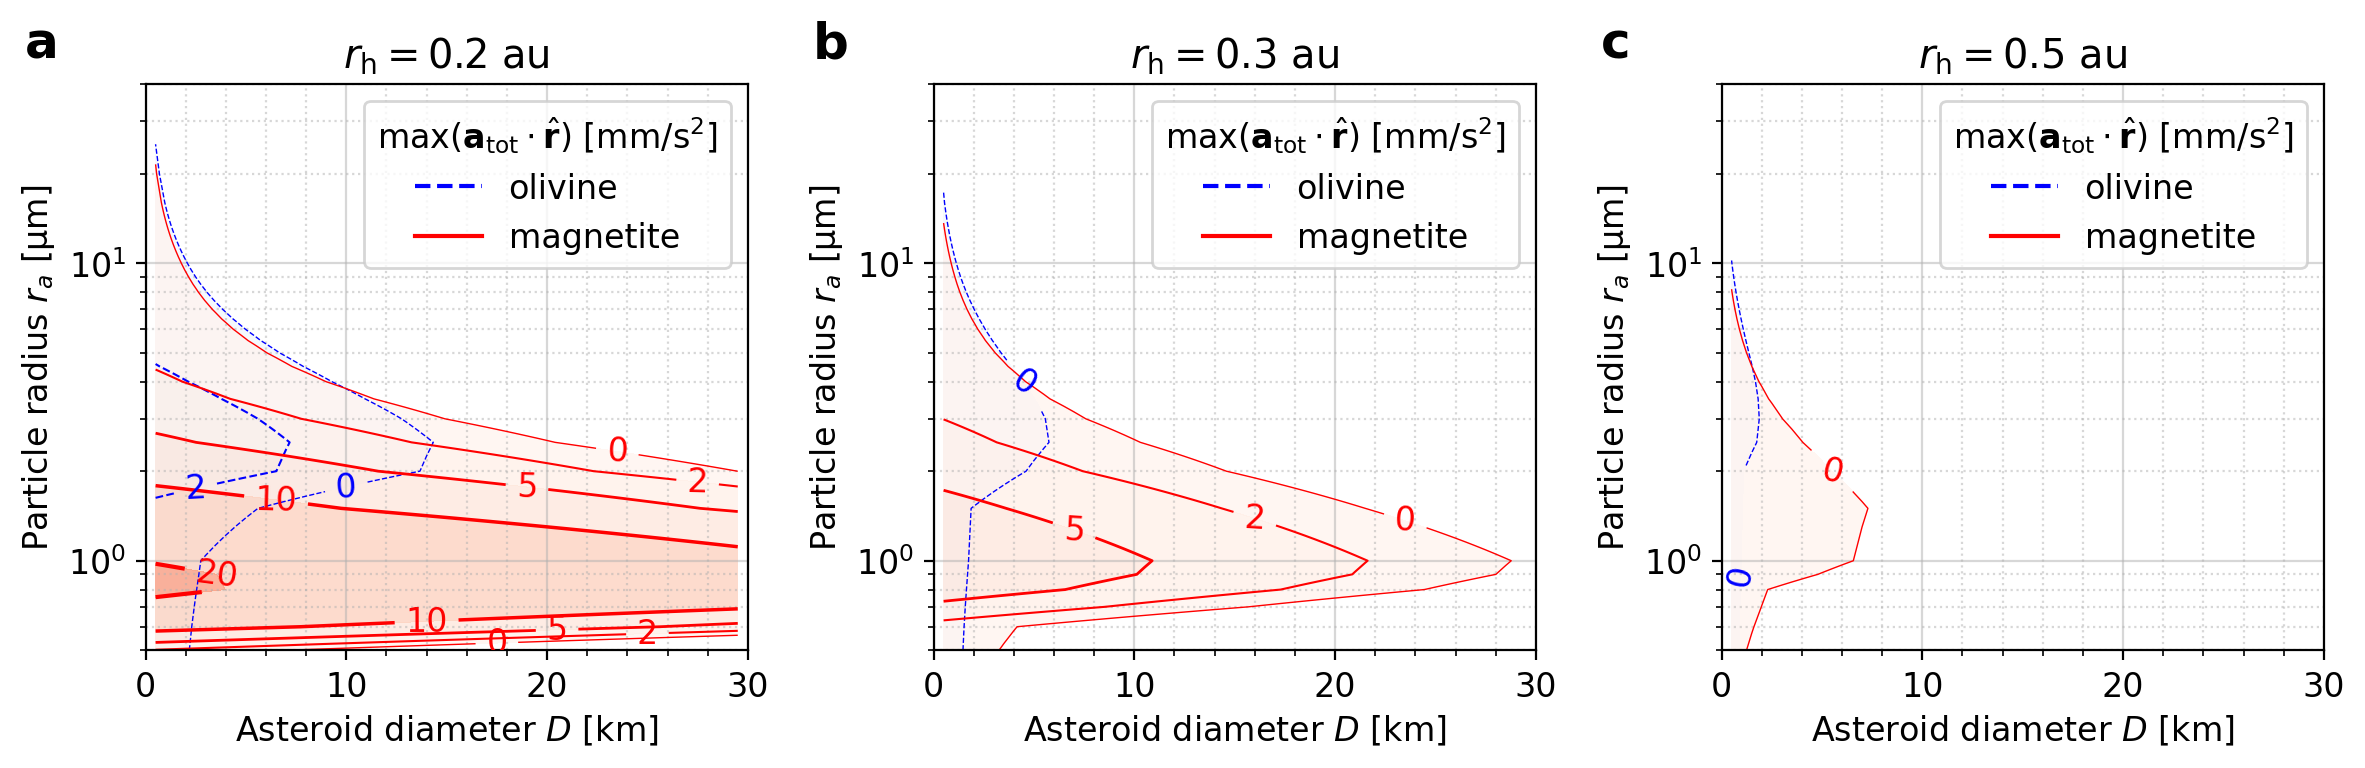

In [6]:
r_h_plot = [RHELS[1], RHELS[2], RHELS[4]]
            
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4
prot = 6

fig, axs = plt.subplots(1, 3, figsize=(12, 4), 
                        sharex=False, sharey=False)
axa = axs[0]

for axa, r_h in zip(axs.tolist(), r_h_plot):
    arr = a_fict.fict.sel(asp=ASPANGS[0], r_h=r_h)
    x = arr.D
    y = arr.r
    a_cen = np.tile(x/2 * (2*np.pi/(prot*3600))**2, (N_R, 1))

    # m/s^2 to mm/s^2
    max_o = 1000*(a_cen + arr.sel(chem='oliv', P=prot).max(dim='ph').T)
    max_m = 1000*(a_cen + arr.sel(chem='mag', P=prot).max(dim='ph').T)

    for k, arr in zip(['o', 'm'], [max_o, max_m]):
        c = kws[k]['c']
        l = kws[k]['lab']
        ls = kws[k]['ls']
        cm = kws[k]['cmap']
        ca = kws[k]['calpha']
        axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
        cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                         colors=c, linestyles=ls)
        cs.clabel(fmt="%.0f", colors=c)
        axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

    axa.set(yscale='log', 
            xlim=(0, 30),
#             ylim=(0.4, 30),
            xlabel="Asteroid diameter $D$ [km]",
            ylabel='Particle radius $r_a$ [µm]',
            title=f"$r_\mathrm{{h}} = {r_h.value:.1f}$ au"
           )
    logyticker(axa, xmajlockws=10, xminlockws=2)
    axa.legend(
        loc=1, 
        title=(r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
    )

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.20, y=1.03, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

    
# plt.suptitle("Fictitious models equator", y=1.02)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

plt.savefig(FIGDIR/f"perp_size-size_{prot:.1f}h.pdf")
plt.savefig(FIGDIR/f"perp_size-size_{prot:.1f}h.png", dpi=300)

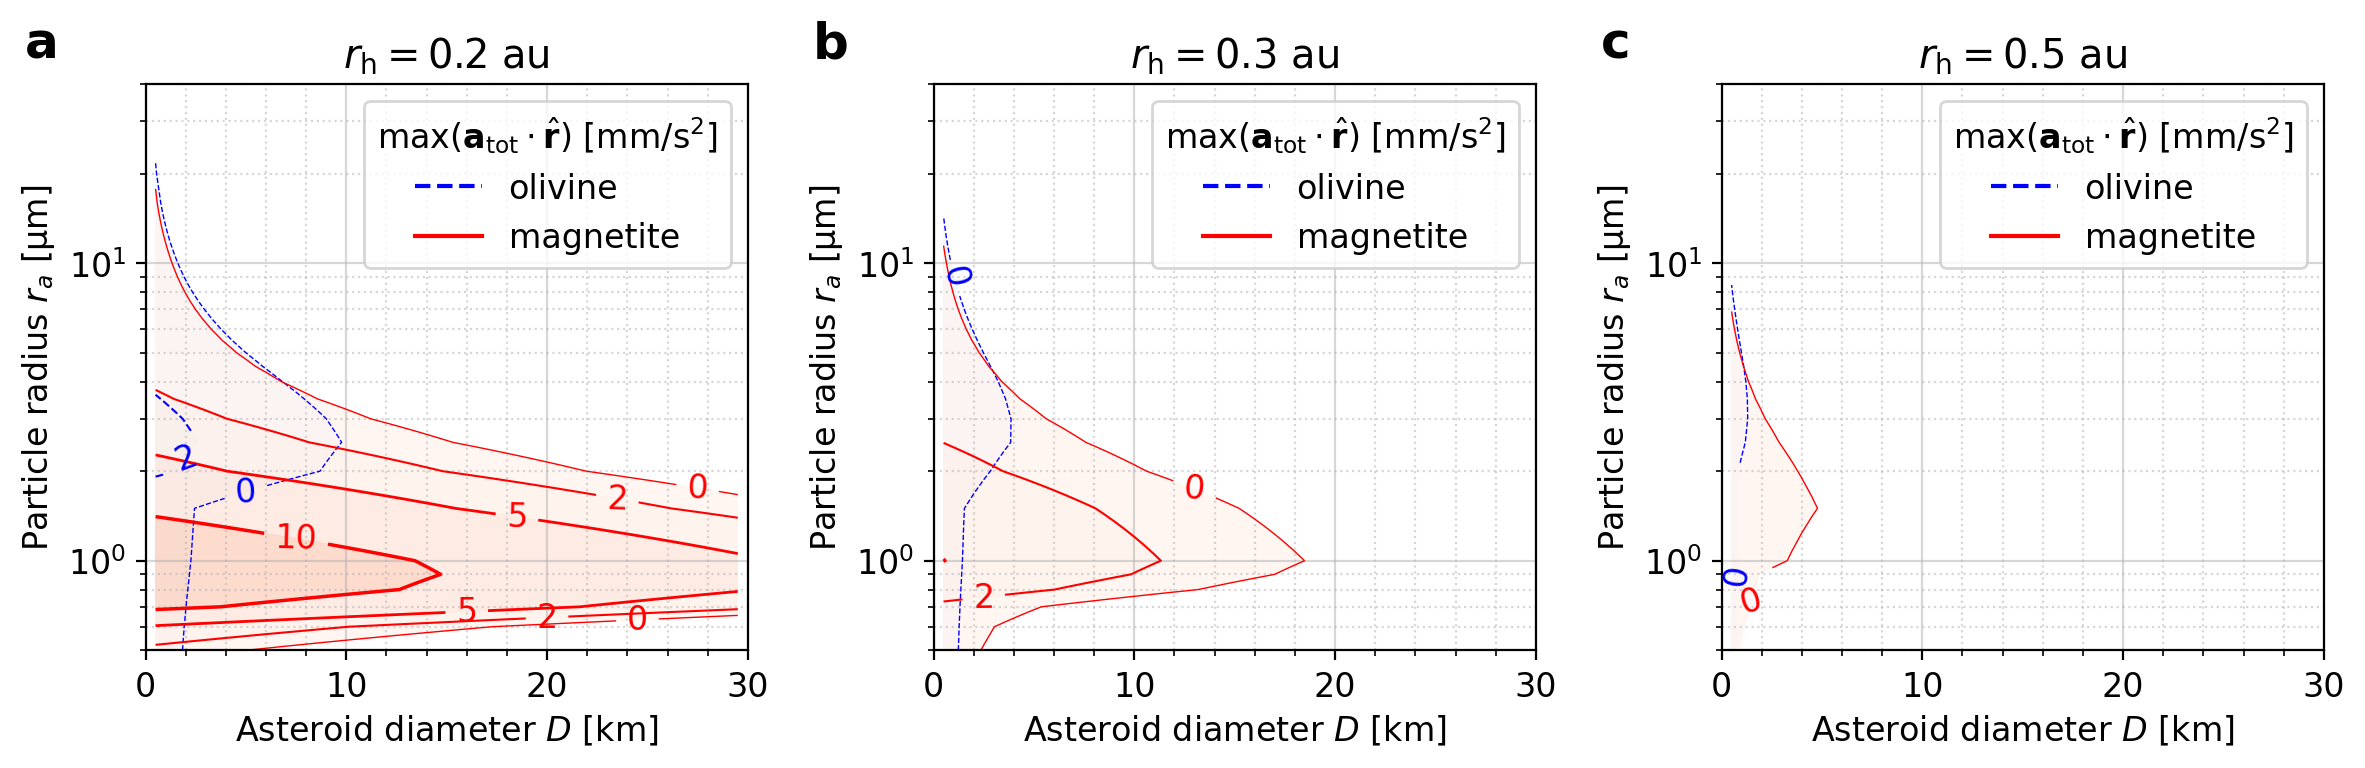

In [7]:
r_h_plot = [RHELS[1], RHELS[2], RHELS[4]]
            
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4
prot = 6

fig, axs = plt.subplots(1, 3, figsize=(12, 4), 
                        sharex=False, sharey=False)
axa = axs[0]

for axa, r_h in zip(axs.tolist(), r_h_plot):
    arr = a_fict.fict.sel(asp=ASPANGS[1], r_h=r_h)
    x = arr.D
    y = arr.r
    a_cen = np.tile(x/2 * (2*np.pi/(prot*3600))**2, (N_R, 1))

    # m/s^2 to mm/s^2
    max_o = 1000*(a_cen + arr.sel(chem='oliv', P=prot).max(dim='ph').T)
    max_m = 1000*(a_cen + arr.sel(chem='mag', P=prot).max(dim='ph').T)

    for k, arr in zip(['o', 'm'], [max_o, max_m]):
        c = kws[k]['c']
        l = kws[k]['lab']
        ls = kws[k]['ls']
        cm = kws[k]['cmap']
        ca = kws[k]['calpha']
        axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
        cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                         colors=c, linestyles=ls)
        cs.clabel(fmt="%.0f", colors=c)
        axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

    axa.set(yscale='log', 
            xlim=(0, 30),
#             ylim=(0.4, 30),
            xlabel="Asteroid diameter $D$ [km]",
            ylabel='Particle radius $r_a$ [µm]',
            title=f"$r_\mathrm{{h}} = {r_h.value:.1f}$ au"
           )
    logyticker(axa, xmajlockws=10, xminlockws=2)
    axa.legend(
        loc=1, 
        title=(r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
    )


for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.20, y=1.03, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

# plt.suptitle("Fictitious models equator", y=1.02)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

plt.savefig(FIGDIR/f"th45_size-size_{prot:.1f}h.pdf")
plt.savefig(FIGDIR/f"th45_size-size_{prot:.1f}h.png", dpi=300)

In [8]:
u_acc = u.mm/u.s**2
(2*np.pi*tm.GG_Q/3 * 2000*u.kg/u.m**3 * 1*u.km).to(u_acc), (2*np.pi**2*1*u.km / (6*u.h)**2).to(u_acc), tm.T_eqm(0.5, r_hel=1)

(<Quantity 0.27957242 mm / s2>,
 <Quantity 0.04230797 mm / s2>,
 <Quantity 339.82831862 K>)

## Phaethon

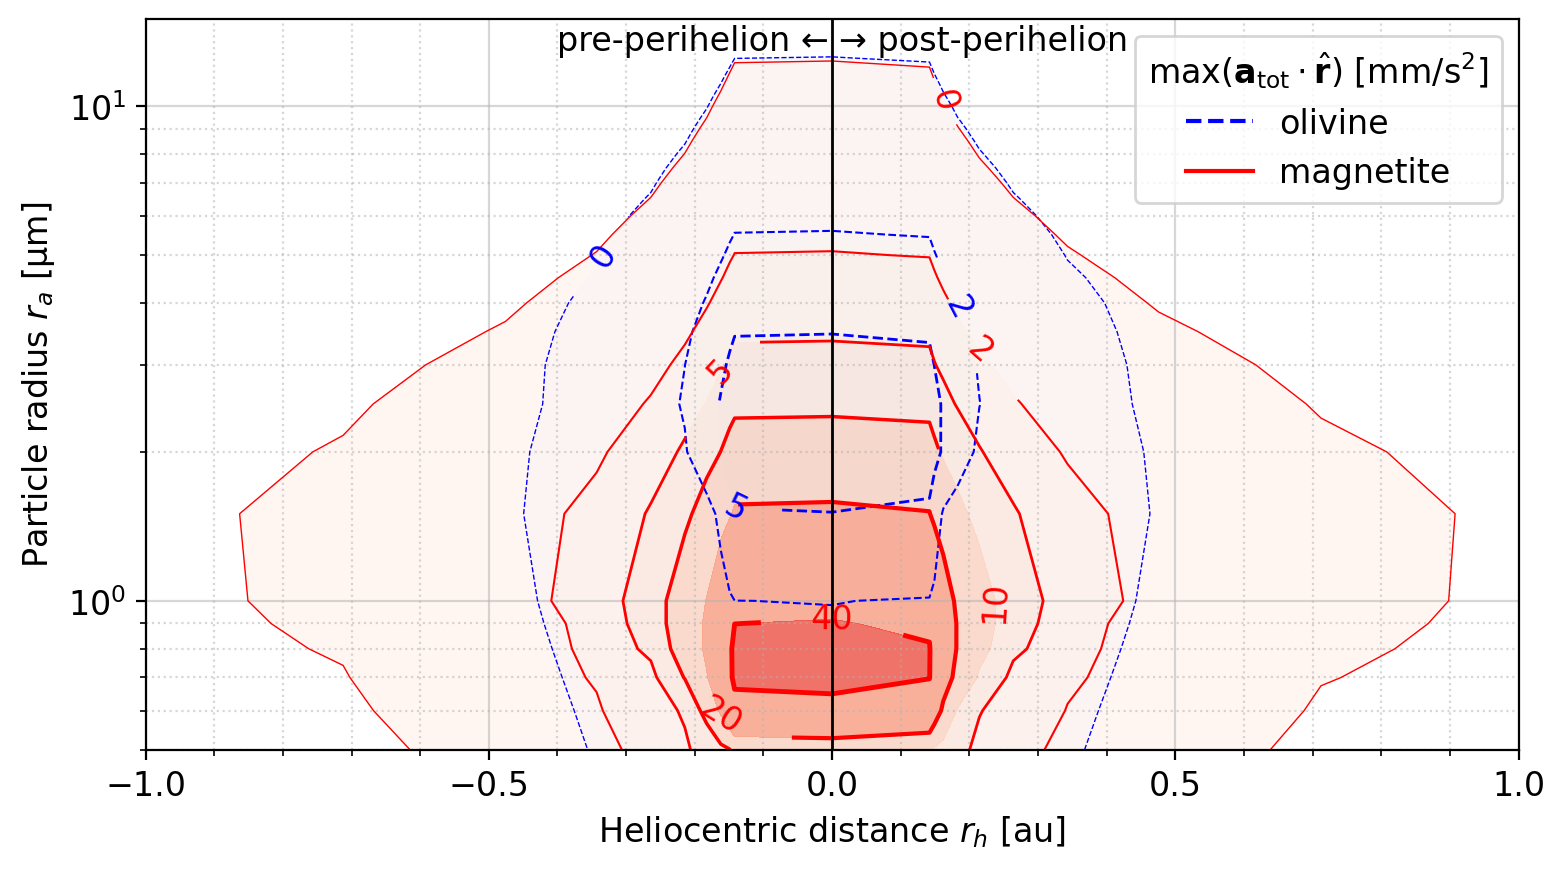

In [9]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']

fig, axs = plt.subplots(1, 1, figsize=(8, 4.5), 
                        sharex=True, sharey=False)#, gridspec_kw={'height_ratios':[5, 2]})
axa = axs

x = r_hel(wrap_180180_to_000360(a_phae.f)) * np.sign(a_phae.f)
y = a_phae.r
m_phae = set_phaethon()
a_cen = (m_phae.radi_eff * m_phae.rot_omega**2).si.value

# m/s^2 to mm/s^2
max_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', th=90).max(dim='ph').T)
max_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', th=90).max(dim='ph').T)

for k, arr in zip(['o', 'm'], [max_o, max_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
    cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                     colors=c, linestyles=ls)
    cs.clabel(fmt="%.0f", colors=c)
    axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

axa.legend(loc=1, title=r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
axa.set(yscale='log', 
        xlim=(-1, 1),
        ylim=(None, 15),
        ylabel='Particle radius $r_a$ [µm]',
        xlabel="Heliocentric distance $r_h$ [au]"
       )
axa.text(-0.4, 13, "pre-perihelion ←")
axa.text(+0.01, 13, "→ post-perihelion")
axa.axvline(0, lw=1, color='k')
logyticker(axa, xmajlockws=0.5, xminlockws=0.1)

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

# plt.savefig(FIGDIR/"phae_acc_eq.pdf")
# plt.savefig(FIGDIR/"phae_acc_eq.png", dpi=300)

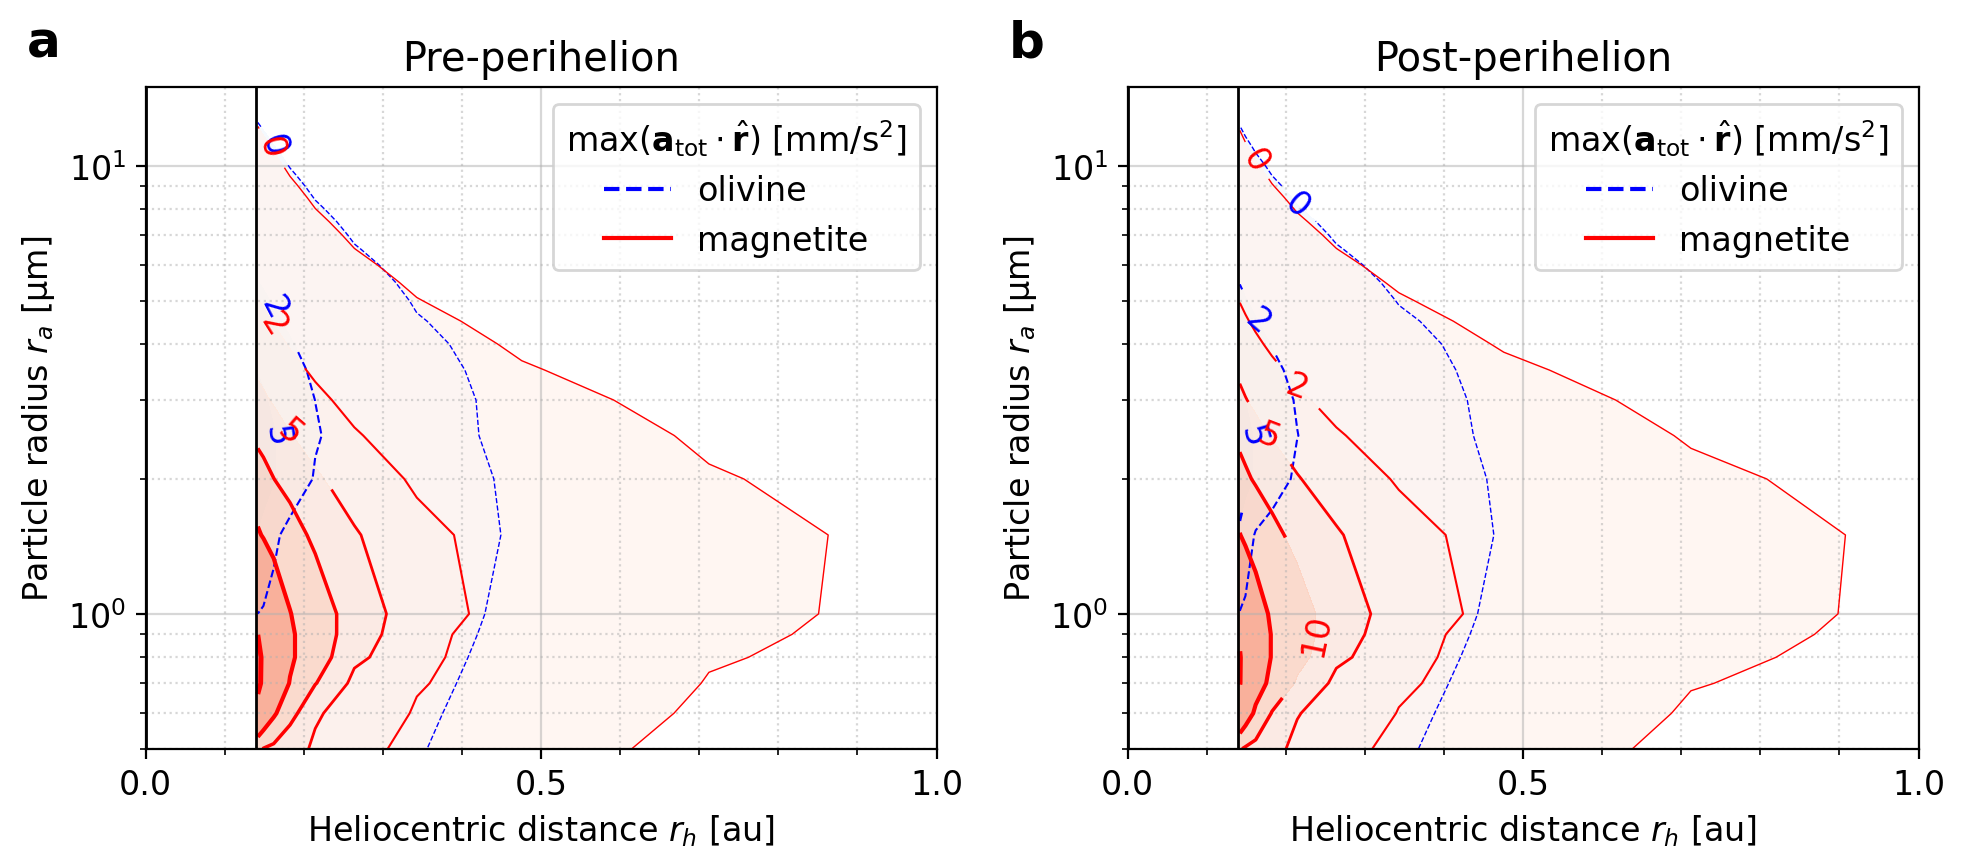

In [10]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

x = r_hel(wrap_180180_to_000360(a_phae.f)) * np.sign(a_phae.f)
y = a_phae.r
m_phae = set_phaethon()
a_cen = (m_phae.radi_eff * m_phae.rot_omega**2).si.value

# m/s^2 to mm/s^2
max_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', th=90).max(dim='ph').T)
max_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', th=90).max(dim='ph').T)

for k, arr in zip(['o', 'm'], [max_o, max_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    for axa, xidx in zip(axs.tolist(), [slice(0, len(x)//2), slice(len(x)//2 + 1, -1)]):
        axa.contourf(np.abs(x[xidx]), y, arr[:, xidx], levels=lvs, cmap=cm, alpha=ca)
        cs = axa.contour(np.abs(x[xidx]), y, arr[:, xidx],  levels=lvs, linewidths=lws, 
                         colors=c, linestyles=ls)
        cs.clabel(fmt="%.0f", colors=c)
        axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

for axa in axs.tolist():
    axa.legend(loc=1, title=r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
    axa.set(yscale='log', 
            ylim=(None, 15),
           )
    axa.axvline(0, lw=1, color='k')
    axa.axvline(0.14, lw=1, color='k')
    axa.axvline(-0.14, lw=1, color='k')
    logyticker(axa, xmajlockws=0.5, xminlockws=0.1)

axs[0].set(
    xlim=(0., 1),
    title="Pre-perihelion",
    ylabel='Particle radius $r_a$ [µm]',
    xlabel="Heliocentric distance $r_h$ [au]"
)
axs[1].set(
    xlim=(0., 1),
    title="Post-perihelion",
    xlabel="Heliocentric distance $r_h$ [au]",
    ylabel='Particle radius $r_a$ [µm]',
)


for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.15, y=1.03, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

plt.savefig(FIGDIR/"phae_acc_eq.pdf")
plt.savefig(FIGDIR/"phae_acc_eq.png", dpi=300)

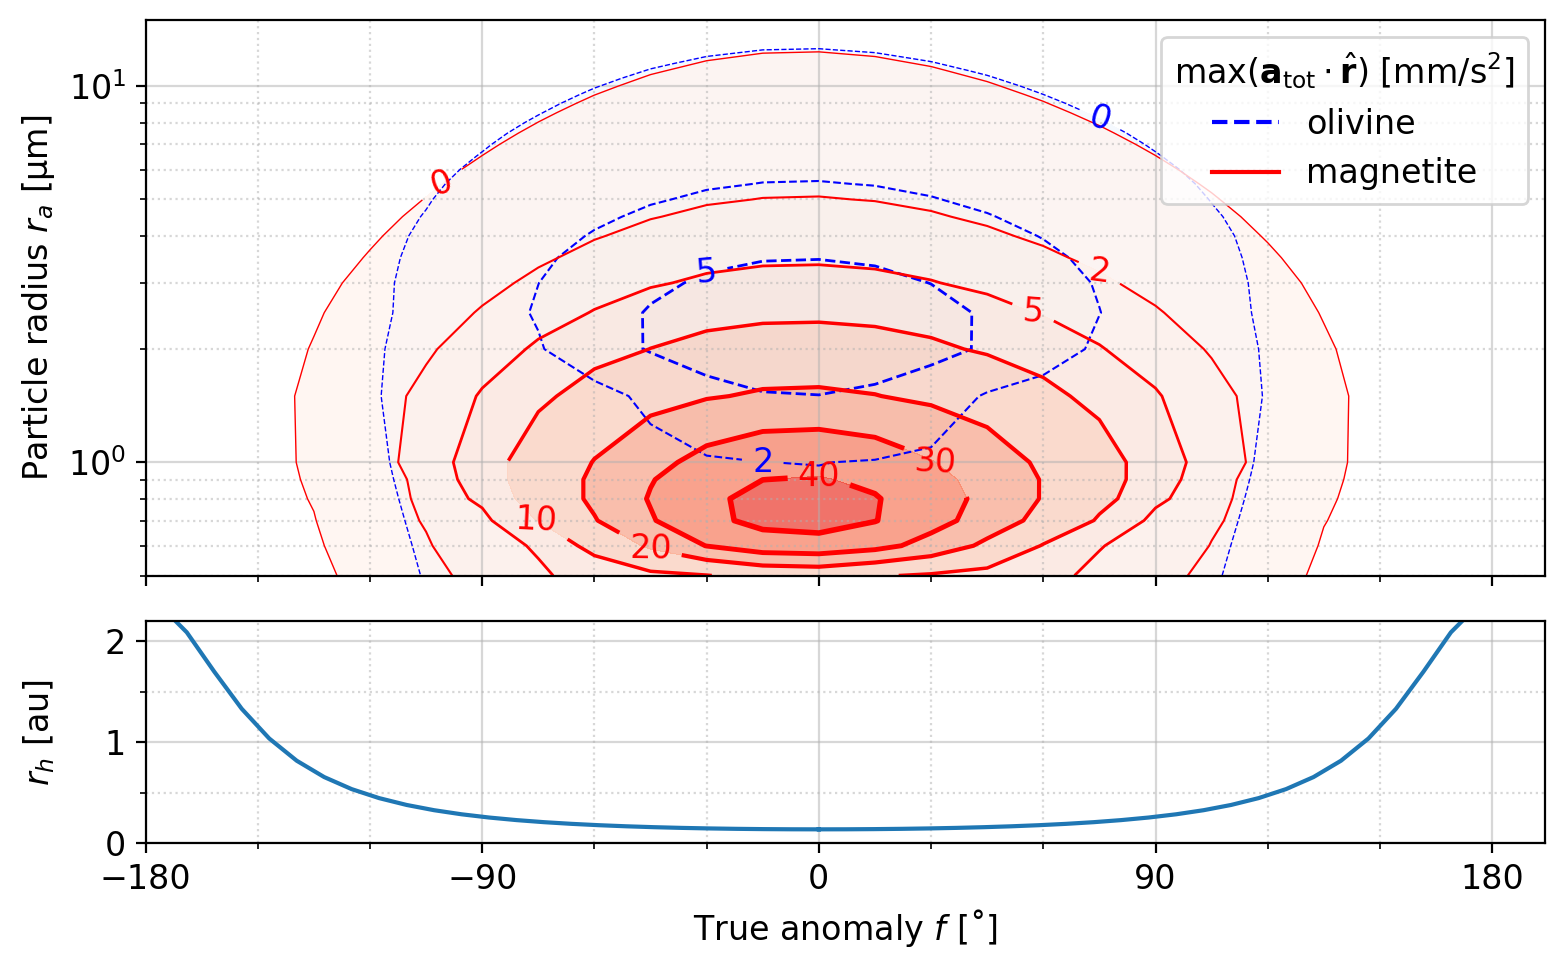

In [11]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 30, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']

fig, axs = plt.subplots(2, 1, figsize=(8, 5), 
                        sharex=True, sharey=False, gridspec_kw={'height_ratios':[5, 2]})
axa, axr = axs.tolist()

x = a_phae.f
y = a_phae.r
a_cen = (m_phae.radi_eff * m_phae.rot_omega**2).si.value

# m/s^2 to mm/s^2
max_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', th=90).max(dim='ph').T)
max_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', th=90).max(dim='ph').T)

for k, arr in zip(['o', 'm'], [max_o, max_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
    cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                     colors=c, linestyles=ls)
    cs.clabel(fmt="%.0f", colors=c)
    axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

# axr.xaxis.set_tick_params(labelbottom=False)
axr.plot(wrap_000360_to_180180(np.linspace(0, 360)), r_hel(np.linspace(0, 360)))

axa.legend(loc=1, title=r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
axa.set(yscale='log', 
        ylim=(None, 15),
        ylabel='Particle radius $r_a$ [µm]',
       )

axr.set(xlabel='True anomaly $f$ [˚]',
        ylabel='$r_h$ [au]', 
        ylim=(0, 2.2), )
logyticker(axa, xmajlockws=90, xminlockws=30)
linticker(axr, 
          ymajlockws=1, yminlockws=0.5, 
          xmajlockws=90, xminlockws=30)

# plt.suptitle("Phaethon, equator", y=1.03)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

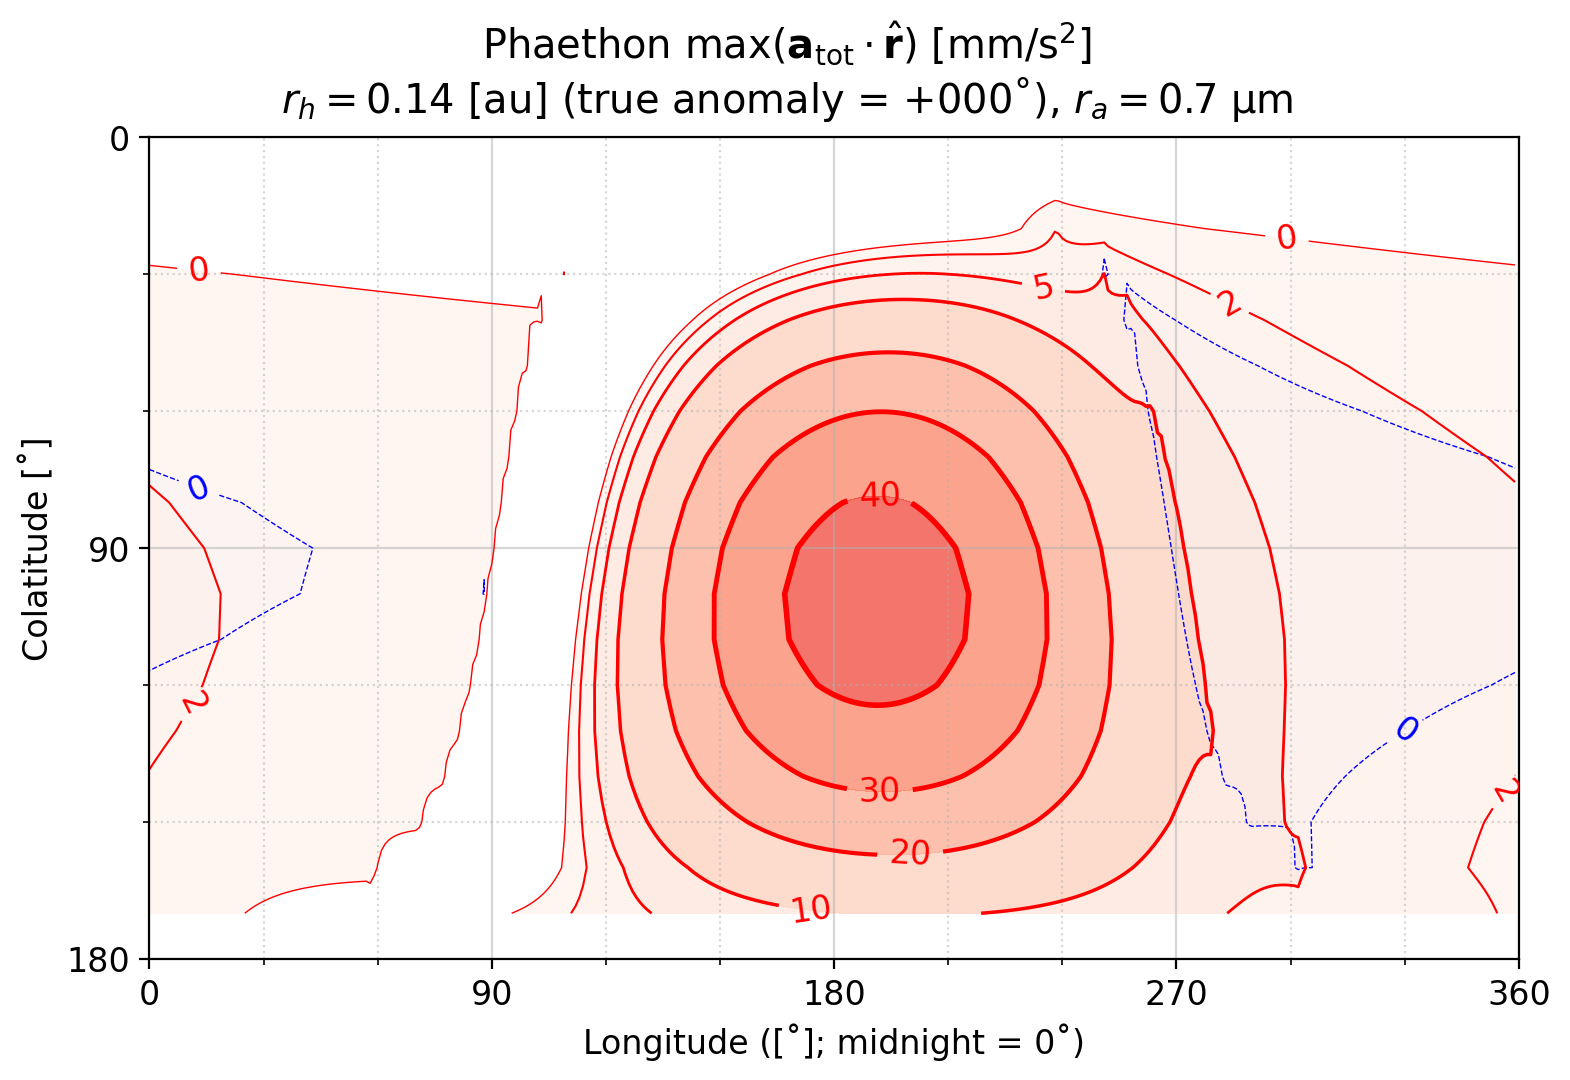

In [12]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 30, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']

fig, ax = plt.subplots(1, 1, figsize=(8, 5)) 

x = a_phae.ph
y = a_phae.th
true_anom = 0
radius_um = 0.7

a_cen = (m_phae.radi_eff.si * np.sin(np.deg2rad(y))
         * m_phae.rot_omega.si**2
         * np.sin(np.deg2rad(y)))

# m/s^2 to mm/s^2
acc_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', f=true_anom, r=radius_um))
acc_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', f=true_anom, r=radius_um))

for k, arr in zip(['o', 'm'], [acc_o, acc_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    ax.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
    cs = ax.contour(x, y, arr, levels=lvs, linewidths=lws, 
                     colors=c, linestyles=ls)
    cs.clabel(fmt="%.0f", colors=c)
    ax.plot(np.nan, np.nan, f"{c}{ls}", label=l)


# ax.legend(loc=10, title=r"$\vec{a}_\mathrm{tot} \cdot \hat{r} ~[\mathrm{mm/s^2}]$")
ax.set(ylim=(180, 0),
       xlim=(0, 360),
       ylabel='Colatitude [˚]',
       xlabel='Longitude ([˚]; midnight = 0˚)'
       )
# logyticker(axa, xmajlockws=90, xminlockws=30)
linticker(ax, 
          xmajlockws=90, xminlockws=30, 
          ymajlockws=90, yminlockws=30)

str_rh = r"$r_h = {:.2f} ~[\mathrm{{au}}]$".format(r_hel(wrap_180180_to_000360(true_anom)))
str_ta = f"true anomaly = {true_anom:+04.0f}˚"
str_ra = r"$r_a = {:.1f}$ µm".format(radius_um)
str_ar = r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$"
plt.suptitle(("Phaethon " + str_ar + '\n' + f"{str_rh} ({str_ta}), {str_ra}"), y=1.07)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()


Some **artifacts in the contour lines** are visibel above, because the acceleration was calculated with latitude step of 10˚ (``TH_0_CALC``) to reduce the computation time (N.B. temperature was calcualted with 1˚ resolution). If I increase the resolution to, e.g., 1˚, it will take 5 hours for my laptop to calculate the ``acc_phae.nc``.

## Regional Acceleration Map on Phaethon

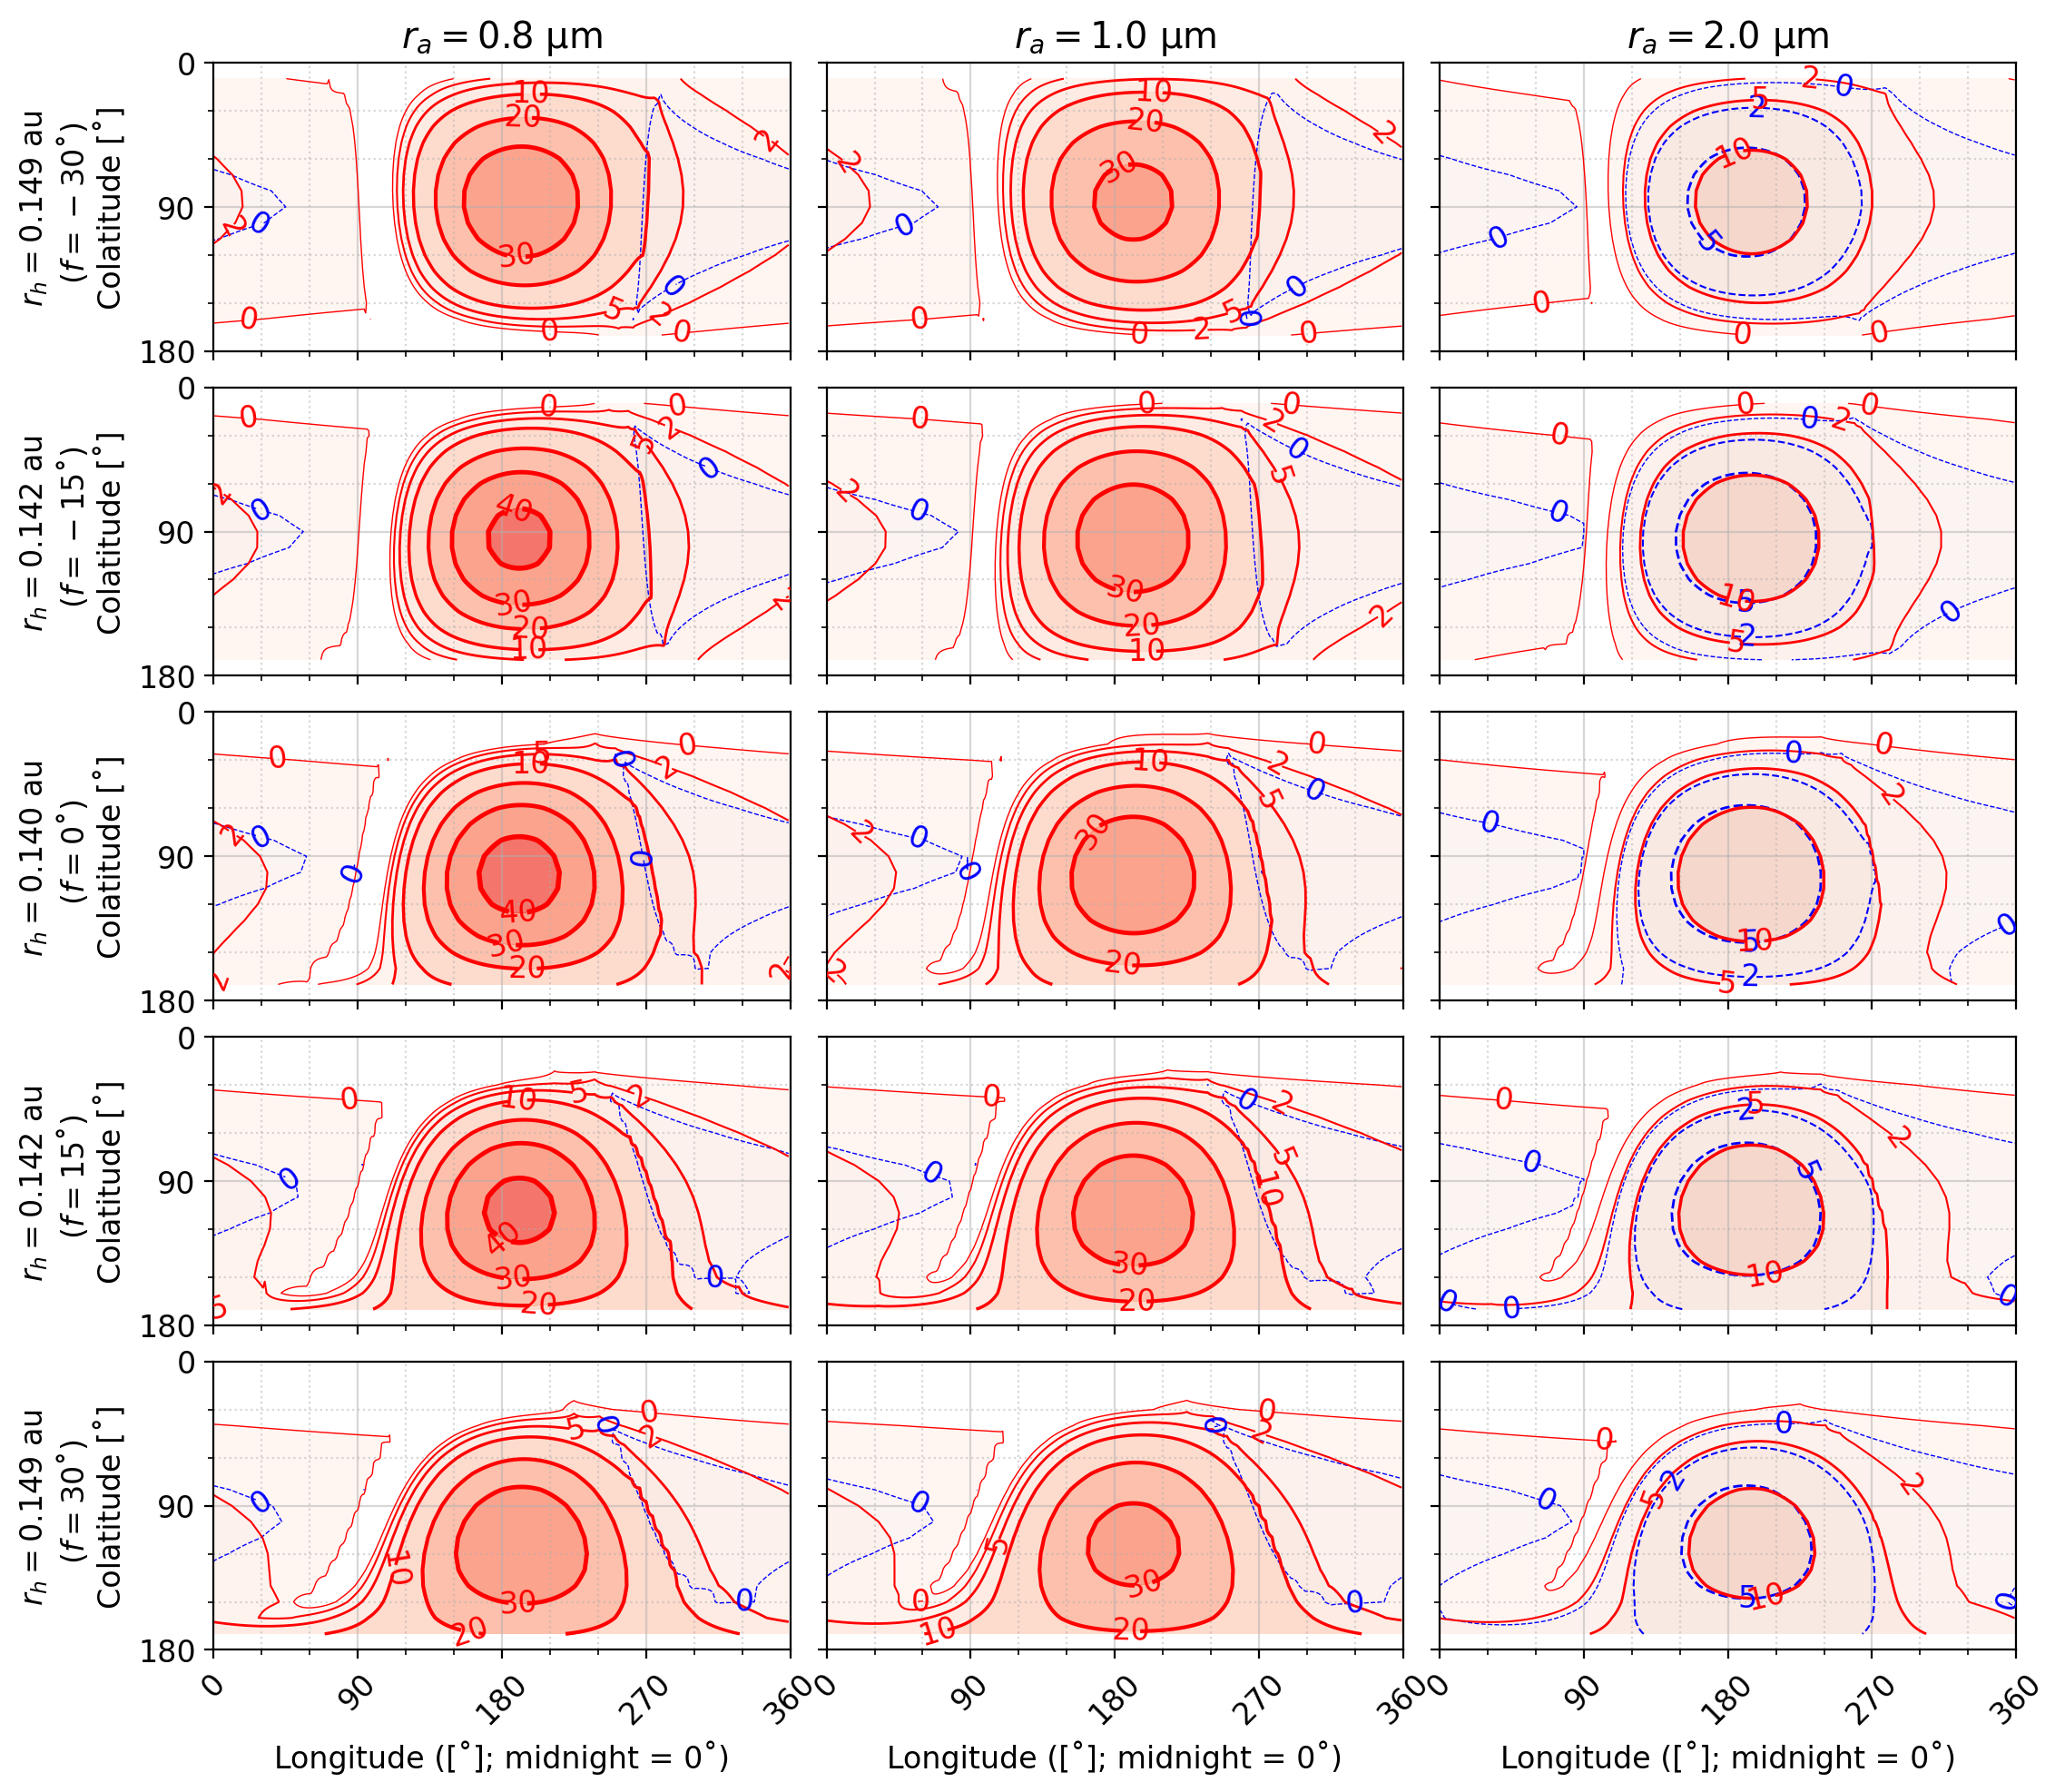

In [13]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 30, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']

fig = plt.figure(figsize=(12., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 3), axes_pad=0.2, label_mode="L")

x = a_phae.ph
y = a_phae.th
a_cen = (m_phae.radi_eff.si * np.sin(np.deg2rad(y))
         * m_phae.rot_omega.si**2
         * np.sin(np.deg2rad(y)))

for i_f, true_anom in enumerate(np.arange(-30, 31, 15)):
    for i_r, radius_um in enumerate([RADII[3], RADII[5], RADII[7]]):
        ax = grid[i_f*3+i_r]
        fr = dict(f=true_anom, r=radius_um)
        # m/s^2 to mm/s^2
        acc_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', **fr))
        acc_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', **fr))

        for k, arr in zip(['o', 'm'], [acc_o, acc_m]):
            c = kws[k]['c']
            l = kws[k]['lab']
            ls = kws[k]['ls']
            cm = kws[k]['cmap']
            ca = kws[k]['calpha']
            ax.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)

            cs = ax.contour(x, y, arr, levels=lvs, linewidths=lws, 
                             colors=c, linestyles=ls)
            cs.clabel(fmt="%.0f", colors=c)
            ax.plot(np.nan, np.nan, f"{c}{ls}", label=l)


        # ax.legend(loc=10, title=r"$\vec{a}_\mathrm{tot} \cdot \hat{r} ~[\mathrm{mm/s^2}]$")
        str_rh = r"$r_h = {:.3f}$ au".format(r_hel(wrap_180180_to_000360(true_anom)))
        str_ta = r"$f = {:.0f}$˚".format(true_anom)
        ax.set(ylim=(180, 0),
               xlim=(0, 360),
               ylabel=f'{str_rh} \n ({str_ta})\nColatitude [˚]',
               xlabel='Longitude ([˚]; midnight = 0˚)'
              )
        ax.tick_params(axis='x', rotation=45)
        linticker(ax, 
                  xmajlockws=90, xminlockws=30, 
                  ymajlockws=90, yminlockws=30)
        if i_f == 0:
            ax.set_title(r"$r_a = {:.1f}$ µm".format(radius_um))

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

plt.savefig(FIGDIR/"phae_accmap_agg.pdf")
plt.savefig(FIGDIR/"phae_accmap_agg.png", dpi=300)

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore', append=True)

kws = dict(
    o=dict(c='b', lab='olivine', ls='--'),
    m=dict(c='r', lab='magnetite', ls='-'),
)
lvs = [0, 2, 5, 10, 20, 40, 60]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']
x = a_phae.ph
y = a_phae.th

a_cen = (m_phae.radi_eff.si * np.sin(np.deg2rad(y))
         * m_phae.rot_omega.si**2
         * np.sin(np.deg2rad(y)))


def plot_func(radius_um, true_anom):
    fig, axs = plt.subplots(1, 1, figsize=(8, 5)) 
    ax = axs

    # m/s^2 to mm/s^2
    acc_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', f=true_anom, r=radius_um))
    acc_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', f=true_anom, r=radius_um))

    for k, arr in zip(['o', 'm'], [acc_o, acc_m]):
        c = kws[k]['c']
        l = kws[k]['lab']
        ls = kws[k]['ls']
        cs = ax.contour(x, y, arr, levels=lvs, linewidths=lws, 
                         colors=c, linestyles=ls)
        cs.clabel(fmt="%.0f", colors=c)
        ax.plot(np.nan, np.nan, f"{c}{ls}", label=l)


    # ax.legend(loc=10, title=r"$\vec{a}_\mathrm{tot} \cdot \hat{r} ~[\mathrm{mm/s^2}]$")
    ax.set(ylim=(180, 0),
           xlim=(0, 360),
           ylabel='Colatitude [˚]',
           xlabel='Longitude ([˚]; midnight = 0˚)'
          )
    # logyticker(axa, xmajlockws=90, xminlockws=30)
    linticker(ax, 
              xmajlockws=90, xminlockws=30, 
              ymajlockws=90, yminlockws=30)

    str_rh = r"$r_h = {:.2f} ~[\mathrm{{au}}]$".format(r_hel(wrap_180180_to_000360(true_anom)))
    str_ta = r"$\mathrm{{true~anomaly}} = {:+04.0f}^\circ$".format(true_anom)
    str_ra = r"$r_a = {:.1f}$ µm".format(radius_um)
    str_ar = r"$\mathrm{max}(\mathbf{a}_\mathrm{tot} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$"
    plt.suptitle(("Phaethon " + str_ar + '\n' + f"{str_rh} ({str_ta}), {str_ra}"), y=1.07)
    plt.tight_layout()
    fig.align_ylabels(axs)
    fig.align_xlabels(axs)
    plt.show()

    
s_r = widgets.SelectionSlider(description=r"$r_a$ [µm]", 
                              options=RADII[:24], value=1)    
fvals_slider = np.roll(wrap_000360_to_180180(TRUE_ANOMS), shift=N_F//2)#[5:-4]
s_f = widgets.SelectionSlider(description="True anom [˚]", 
                              options=fvals_slider,
                              continuous_update=False,
                              value=0)

interact(plot_func, radius_um=s_r, true_anom=s_f)

interactive(children=(SelectionSlider(description='$r_a$ [µm]', index=5, options=(0.5, 0.6, 0.7, 0.79999999999…

<function __main__.plot_func(radius_um, true_anom)>

## Timing Benchmark

In [15]:
rh = 0.2
diam_eff = 1000
rot_per = 6

sb_perp = set_model_aspect(r_hel=rh, aspect_deg=90, 
                           diam_eff=diam_eff, rot_period=rot_per, 
                           **TPM_BASE)
sb_th45 = set_model_aspect(r_hel=rh, aspect_deg=45, 
                           diam_eff=diam_eff, rot_period=rot_per, 
                           **TPM_BASE)
sb_perp.calc_temp(full=False)
sb_th45.calc_temp(full=False)

In [16]:
%%timeit
a_perps = {}
a_th45s = {}
a_phaes = {}

for chem in chemkeys[:1]:
    # Splining Qprbar is the most time-consuming part (~ 20ms)
    # compared to all others (< 1ms), so better to give a priori if possible.
    kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
    for d in DIAMS[:1]:
        for p in PROTS[:1]:
            for r in RADII[:1]:
                acc_perp = []
                acc_th45 = []
                for ph in PH_0_CALC:
                    kw_p = dict(radius_um=r, chem=chem, 
                                init_th=90, init_ph=ph, **kw_Q)
                    particle_perp = set_particle(sb_perp, **kw_p)
                    particle_th45 = set_particle(sb_th45, **kw_p)
                    a_perp = np.sum(particle_perp.trace_a_all_xyz[-1]
                                    *particle_perp.trace_rvec[-1])
                    a_th45 = np.sum(particle_th45.trace_a_all_xyz[-1]
                                    *particle_th45.trace_rvec[-1])
                    acc_perp.append(a_perp)
                    acc_th45.append(a_th45)
                a_perps[d, p, r] = np.array(acc_perp)
                a_th45s[d, p, r] = np.array(acc_th45)

601 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# Estimated time for calculation for all radii
len(RADII) * 0.448  # cuz I got 448 ms from above

18.368000000000002

In [18]:
import time
npools = np.arange(15) + 1
times = []
for npool in npools:
    print(npool, end=' ')
    start = time.time()
    a_perps = {}
    a_th45s = {}
    a_phaes = {}

    for chem in chemkeys[:1]:
        # Splining Qprbar is the most time-consuming part (~ 20ms)
        # compared to all others (< 1ms), so better to give a priori if possible.
        kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                    Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
        for d in DIAMS[:1]:
            for p in PROTS[:1]:
                def _acc_multi(radius):  # d, p, sb are already defined outside.
                    acc_perp = []
                    acc_th45 = []
                    for ph in PH_0_CALC:
                        kw_p = dict(radius_um=radius, chem=chem, 
                                    init_th=90, init_ph=ph, **kw_Q)
                        particle_perp = set_particle(sb_perp, **kw_p)
                        particle_th45 = set_particle(sb_th45, **kw_p)
                        a_perp = np.sum(particle_perp.trace_a_all_xyz[-1]
                                        * particle_perp.trace_rvec[-1])
                        a_th45 = np.sum(particle_th45.trace_a_all_xyz[-1]
                                        * particle_th45.trace_rvec[-1])
                        acc_perp.append(a_perp)
                        acc_th45.append(a_th45)
                    return radius, np.array(acc_perp), np.array(acc_th45)

                pool = Pool(npool)
                args = [RADII]
                results = np.array(pool.starmap(_acc_multi, np.array(args).T))
                pool.close()

                for res in results:
                    a_perps[d, p, res[0]*u.um] = res[1]
                    a_th45s[d, p, res[0]*u.um] = res[1]
    times.append(time.time() - start)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

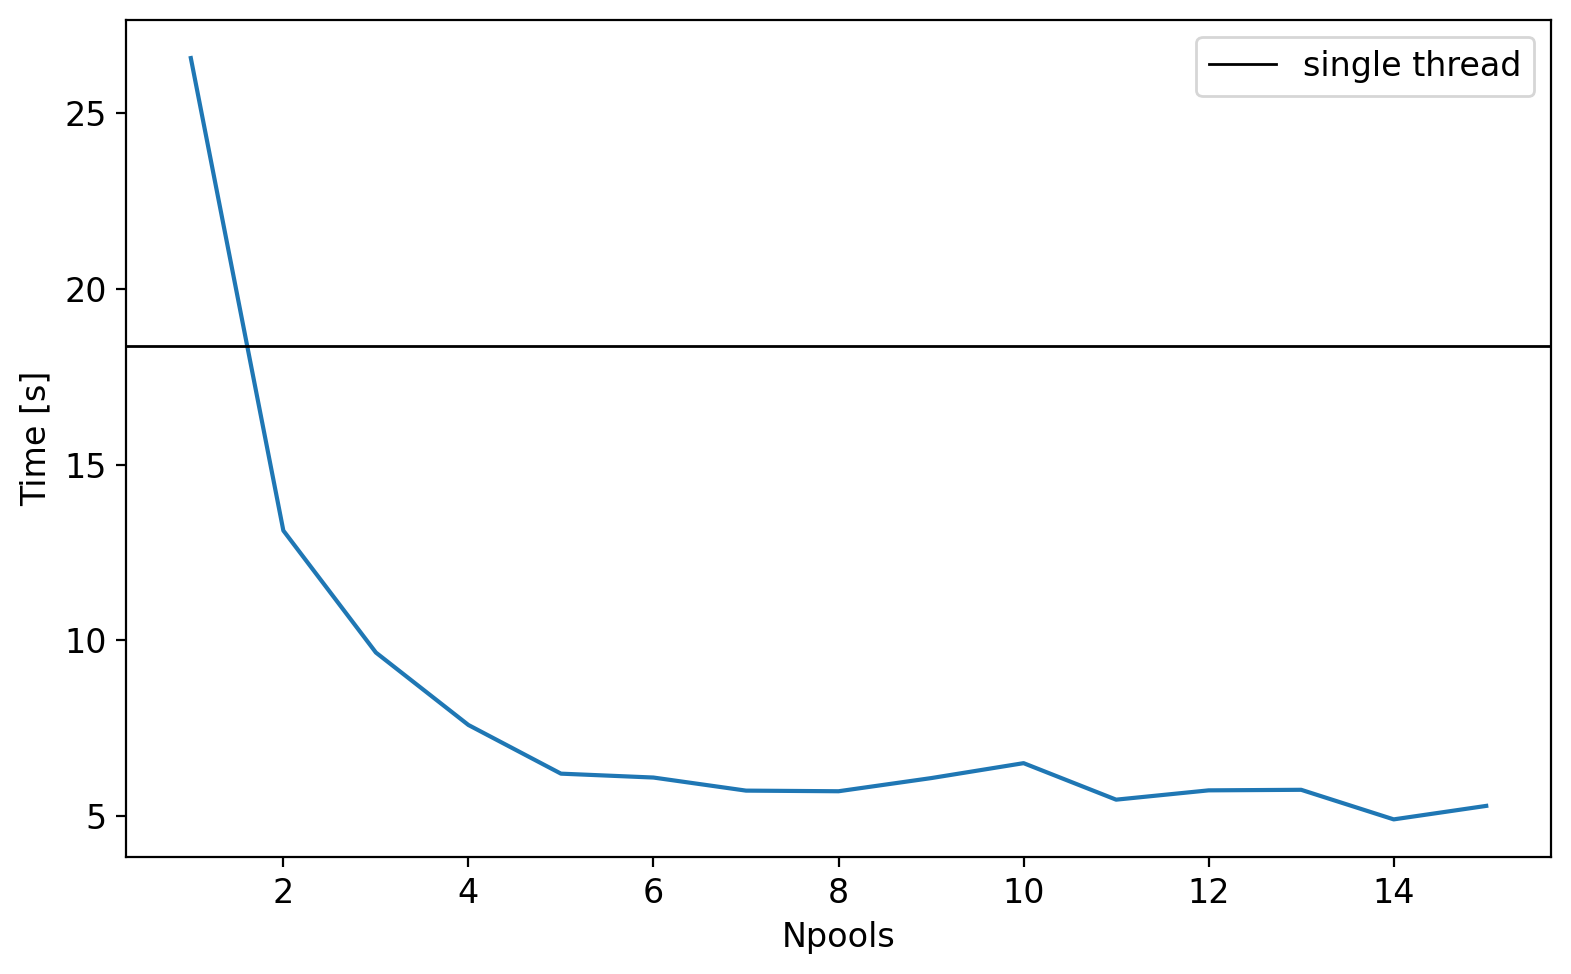

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), 
                        sharex=False, sharey=False, gridspec_kw=None)
axs.plot(npools, times)
axs.axhline(0.448*len(RADII), color='k', lw=1, label='single thread')  # single thread time
axs.set(xlabel="Npools", ylabel="Time [s]")
axs.legend()
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

968So I used ``npool_optimal = 7``.